In [166]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import json
from sklearn.model_selection import KFold
from collections import defaultdict
import matplotlib.pyplot as plt
import shap

import sys
sys.path.append("..")
sys.path.append("../../../qtrees-ai-data-private")

from qtreesprivate.preprocessed_data import Preprocessor

from qtrees.helper import get_logger, init_db_args
from qtrees.constants import NOWCAST_FEATURES, FORECAST_FEATURES

from qtreesprivate.plots_util import apply_qtrees_style
import matplotlib.style as style
style.use("../../../qtrees-ai-data-private/data/baumblick.mplstyle")

pd.set_option('display.max_columns', None)
DEPTH_MAP = {1: "30 cm", 2: "60 cm", 3: "90 cm"}

CAT_FEATURES = ["baumscheibe_surface", "gattung", "month", "baumscheibe_cat", "standalter_cat"]
NUM_FEATURES = ["water_sga","water_gdk", "shading_index", "wind_max_ms", "rainfall_mm", "temp_avg_c", "ghi_sum_whm2", "gestern", "upm"]

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# # dev
# user = "qtrees_user"
# postgres_passwd = "cn%40E!msD6*-UACxV_FeXpd.p"
# db_qtrees = "qtreesdev-iac-rds.ct3edyn2bzjb.eu-central-1.rds.amazonaws.com"

# engine = create_engine(
#     f"postgresql://{user}:{postgres_passwd}@{db_qtrees}:5432/qtrees"
# )

# pp = Preprocessor(engine)
# pp.processing_pipeline()
# data = pp.data
# data.info()
# data.to_pickle("data.p")

# tree_devices = pd.read_sql(con= engine, sql="SELECT * FROM private.tree_devices")
# #tree_devices.to_pickle("tree_devices.p")

In [168]:
def pick_test_weeks(weeks, n_train_weeks=5, n_test_weeks=4):
    train_weeks, test_weeks = [], []

    i = 0
    while i + n_train_weeks  < len(weeks):
        # Define the training period
        train_start = weeks[i]
        train_end = weeks[i + min(n_train_weeks, len(weeks) - i) - 1]

        # Define the testing period
        test_start = weeks[i + n_train_weeks]
        if i + n_train_weeks + n_test_weeks < len(weeks):
            test_end = weeks[i + n_train_weeks + n_test_weeks -1]
        else:
            test_end = weeks[-1]
        
        train_weeks.extend(range(train_start, train_end + 1))  
        test_weeks.extend(range(test_start, test_end + 1)) 

        i = i + n_train_weeks + n_test_weeks 

    return train_weeks, test_weeks

def create_train_test_split_across_sites(data, n_splits=4):
    train_data_folds, test_data_folds = [], []

    # Create a KFold object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    site_ids = data.site_id.unique()

    for train_index, test_index in kf.split(site_ids):
        train_data = data[data.site_id.isin(site_ids[train_index])]
        test_data = data[data.site_id.isin(site_ids[test_index])]

        # calculate the feature across only the train data and use it also for testing
        temp = train_data.groupby(["timestamp","type_id"])["value"].mean().shift(1).rename("gestern")
        train_data = train_data.merge(temp, left_on=["timestamp", "type_id"], right_index=True)
        test_data = test_data.merge(temp, left_on=["timestamp", "type_id"], right_index=True)

        train_data_folds.append(train_data.dropna())
        test_data_folds.append(test_data.dropna())

    return list(zip(train_data_folds, test_data_folds))


def log_experiment_results(fold_results, experiment_id="experiment1", model="RandomForestRegressor", features=[], hyper_parameters={}, csv_file="experiments.csv"):
    df = pd.DataFrame([{"experiment_id": experiment_id, 
                        "Mean 30cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 30cm"]]),2) for key in fold_results["Folds 30cm"][0]}),
                        "Mean 60cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 60cm"]]),2) for key in fold_results["Folds 60cm"][0]}),
                        "Mean 90cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 90cm"]]),2) for key in fold_results["Folds 90cm"][0]}),
                        "Folds 30cm": json.dumps(fold_results["Folds 30cm"]), 
                        "Folds 60cm": json.dumps(fold_results["Folds 60cm"]), 
                        "Folds 90cm": json.dumps(fold_results["Folds 90cm"]), 
                        "model": model, "features": json.dumps(features), 
                        "hyper_parameters": json.dumps(hyper_parameters)}])

    # Check if the file already exists; if not, write the header
    write_header = not pd.io.common.file_exists(csv_file)

    with open(csv_file, 'a', newline='') as file:
        df.to_csv(file, mode='a', index=False, header=write_header)


def read_experiment_log(csv_file):
    data = pd.read_csv(csv_file)
    data['hyper_parameters'] = data['hyper_parameters'].apply(json.loads)
    data['features'] = data['features'].apply(json.loads)
    return data

def predict_depth(model, test_data, type_id = 1, features=[]):
    X_test, y_test = test_data.loc[test_data.type_id==type_id, features], test_data.loc[test_data.type_id==type_id,["value"]]
    
    y_hat =  model.predict(X_test) # y_hat = np.expm1(model.predict(X_test))
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    mae = mean_absolute_error(y_test, y_hat)

    y_test.rename(columns={"value": "y_test"})
    y_test["y_hat"] = y_hat
    y_test["tree_id"] = test_data.loc[test_data.type_id==type_id, "tree_id"]
    y_test["timestamp"] = test_data.loc[test_data.type_id==type_id, "timestamp"]
    y_test["benchmark"] = test_data.loc[test_data.type_id==type_id, "gestern"]

    #print(f"Random Forest: Tiefe {DEPTH_MAP[type_id]}: RMSE {rmse:.2f}, MAE {mae:.2f}")
    return {"rmse": round(rmse, 2), "mae": round(mae, 2)}, y_test


def predict_benchmark(test_data, type_id = 1, features=[]):
    _, y_test = test_data.loc[test_data.type_id==type_id, features], test_data.loc[test_data.type_id==type_id, "value"]
    y_hat_benchmark = test_data.loc[test_data.type_id==type_id, "gestern"]
    rmse = mean_squared_error(y_test, y_hat_benchmark, squared=False)
    mae = mean_absolute_error(y_test, y_hat_benchmark)
    return {"rmse": round(rmse, 2), "mae": round(mae, 2)}

def evaluate_benchmark_on_folds(folds, log_experiment=True):
    fold_results = defaultdict(list)
    for fold in folds:
        fold_results["Folds 30cm"].append(predict_benchmark(fold[1], type_id=1))
        fold_results["Folds 60cm"].append(predict_benchmark(fold[1], type_id=2))
        fold_results["Folds 90cm"].append(predict_benchmark(fold[1], type_id=3))

    if log_experiment:
        log_experiment_results(fold_results, experiment_id="Benchmark", model="Benchmark", features=[], hyper_parameters={})
        
    return fold_results

def init_result_folder(name):
    folder_path = os.path.join(".", name)  # Use "." to create the folder in the current directory

    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
    else:
        os.makedirs(folder_path)

    return folder_path

def plot_predictions(predictions, path):
    y_min, y_max = 0.0, predictions.value.max()
    min_date, max_date = predictions.timestamp.min(), predictions.timestamp.max()
    idx = pd.DatetimeIndex(pd.date_range(start=min_date, end=max_date, freq='D'))

    for tree in predictions.tree_id.unique():
        plot_data = predictions[(predictions.tree_id==tree) & (predictions.type_id==1)].set_index("timestamp").sort_index()
        
        if len(plot_data) > 0:
            mae_forecast = mean_absolute_error(plot_data["value"], plot_data["y_hat"])
            mae_benchmark = mean_absolute_error(plot_data["value"], plot_data["benchmark"])
            plot_data = plot_data.reindex(idx)
            
            fig, ax = plt.subplots(1,2, figsize=(12,5))
            plot_data.value.plot(ax=ax[0], label="Sensorwert")
            plot_data.y_hat.plot(ax=ax[0], label="Vorhersage")
            plot_data.benchmark.plot(ax=ax[0], label="Benchmark")
            ax[0].set_ylim((y_min, y_max))
            ax[0].set_xlim(("2022-04", "2022-09"))
            ax[0].xaxis.grid(False)

            plot_data.value.plot(ax=ax[1], label="Sensorwert")
            plot_data.y_hat.plot(ax=ax[1], label="Vorhersage")
            plot_data.benchmark.plot(ax=ax[1], label="Benchmark")
            ax[1].set_ylim((y_min, y_max))
            ax[1].set_xlim(("2023-04", "2023-09"))
            #ax[1].legend()
            ax[1].xaxis.grid(False)

            apply_qtrees_style(fig,f"Tree {tree}, Tiefe 30cm",f"Vorhersage MAE: {mae_forecast:.2f}, Benchmark MAE: {mae_benchmark:.2f}")
            ax[0].get_legend().set_visible(False)
        
        plt.savefig(os.path.join(path, f"forecast_{tree}.png"), bbox_inches="tight")

def evaluate_folds(folds, name, model, hyper_parameters, features, explain_model=False, log_experiment=True):
    fold_results = defaultdict(list)

    predictions = []

    path = init_result_folder(name)

    for idx, fold in enumerate(folds):
        X_train, y_train = fold[0][features], fold[0]["value"]
        model.fit(X_train, y_train)

        results, predictions30 = predict_depth(model, fold[1], type_id=1, features=features)
        fold_results["Folds 30cm"].append(results)
        predictions30["type_id"] = 1
        results, predictions60 = predict_depth(model, fold[1], type_id=2, features=features)
        fold_results["Folds 60cm"].append(results)
        predictions60["type_id"] = 2
        results, predictions90 = predict_depth(model, fold[1], type_id=2, features=features)
        fold_results["Folds 90cm"].append(results)
        predictions90["type_id"] = 3

        fold_predictions = pd.concat([predictions30, predictions60, predictions90], ignore_index=True)
        fold_predictions["fold"] = idx
        predictions.append(fold_predictions)
    
        if explain_model:
            feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            feature_importance_df.to_csv(os.path.join(path, f"feature_importance_fold_{idx}.csv"))
            feature_importance_df.set_index("Feature").plot(kind="barh");
            plt.savefig(os.path.join(path, f"feature_importance_fold_{idx}.png"), bbox_inches="tight")

            explainer = shap.Explainer(model, X_train)
            shap_values = explainer(X_train)
            shap.plots.bar(shap_values)
            plt.savefig(os.path.join(path, f"shap_values_{idx}.png"), bbox_inches="tight")

            shap.plots.violin(shap_values)
            plt.savefig(os.path.join(path, f"shap_values_violin_{idx}.png"), bbox_inches="tight")


    if log_experiment:
        log_experiment_results(fold_results, experiment_id=name, model=model.__class__.__name__, features=features, hyper_parameters=hyper_parameters)
        
    total_predictions = pd.concat(predictions, ignore_index=True)
    total_predictions.to_csv(os.path.join(path, f"predictions_fold_{idx}.csv"))

    plot_predictions(total_predictions, path)

    return fold_results, total_predictions

In [169]:
data = pd.read_pickle("data.p")
data["water"] = data["water_gdk"] + data["water_sga"]

tree_devices = pd.read_pickle("tree_devices.p")

FEATURES_POC = ["type_id", "standalter_cat", "shading_index", "temp_avg_c", "rainfall_mm", "water_sga", "water_gdk", "month", "gestern"] #, "standalter_cat", "shading_index", 
FEATURES_MVP = ["type_id", "shading_index", "standalter_cat", "temp_avg_c", "rainfall_mm",  "water_sga", "water_gdk", "month", "gestern", "baumscheibe_surface", "gattung", "baumscheibe_cat", "wind_max_ms", "ghi_sum_whm2", "upm"]
FEATURE_NAIVE = ["gestern"]

#data = data.loc[(data.timestamp >= "2022-1")&(data.timestamp < "2023-09"), :].sort_values(["sensor_id", "timestamp"]).dropna(subset=["value"])
#weather_features = ["temp_avg_c", "rainfall_mm", "wind_max_ms", "ghi_sum_whm2", "upm"]
#for c in weather_features:
#    data[c] = data[c].interpolate()

clean_idx = data.loc[data.timestamp < "2023-09", FEATURES_MVP].dropna().index
data = data.loc[clean_idx]
data = data.merge(tree_devices[["tree_id", "site_id"]], how="left", left_on="tree_id", right_on="tree_id")
data = data.drop("gestern", axis=1)

#create categories
CAT_FEATURES = ["baumscheibe_surface", "gattung", "month", "baumscheibe_cat", "standalter_cat"]
for c in [x for x in FEATURES_MVP if x in CAT_FEATURES]:
    data.loc[:, c] = data.loc[:, c].factorize()[0].astype(int)

#for c in [x for x in FEATURES_MVP if x in NUM_FEATURES]:
#    clean_data.loc[:,c] = (clean_data.loc[:,c]-clean_data.loc[:,c].mean())/clean_data.loc[:,c].std()
data.gattung = data.gattung.astype(int)
data.baumscheibe_surface = data.baumscheibe_surface.astype(int)
data.shape

(18005, 26)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

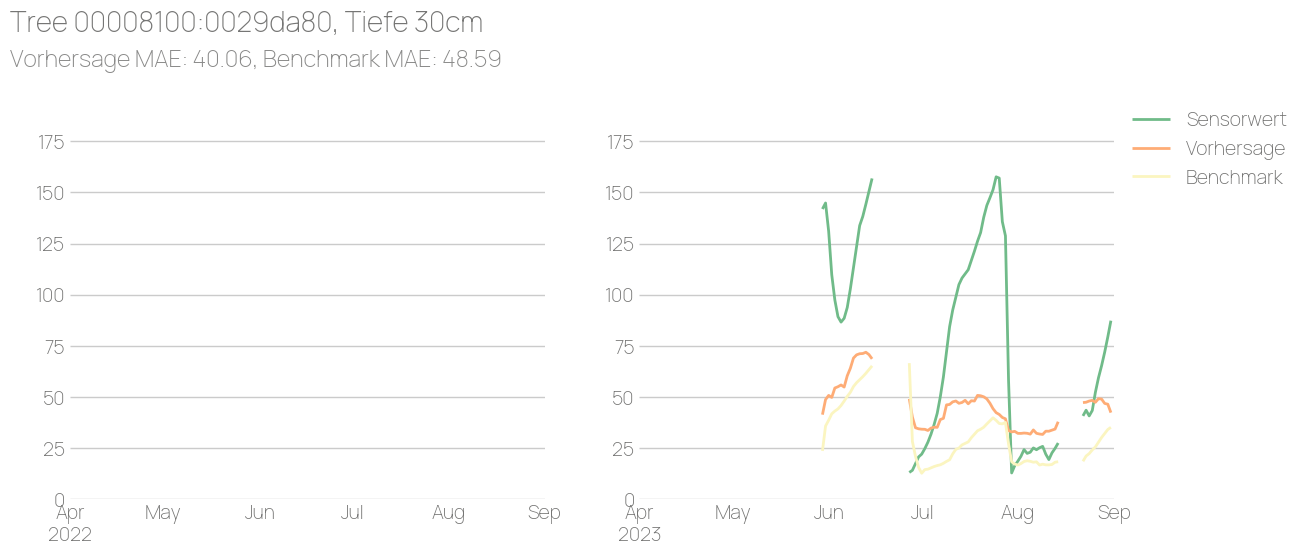

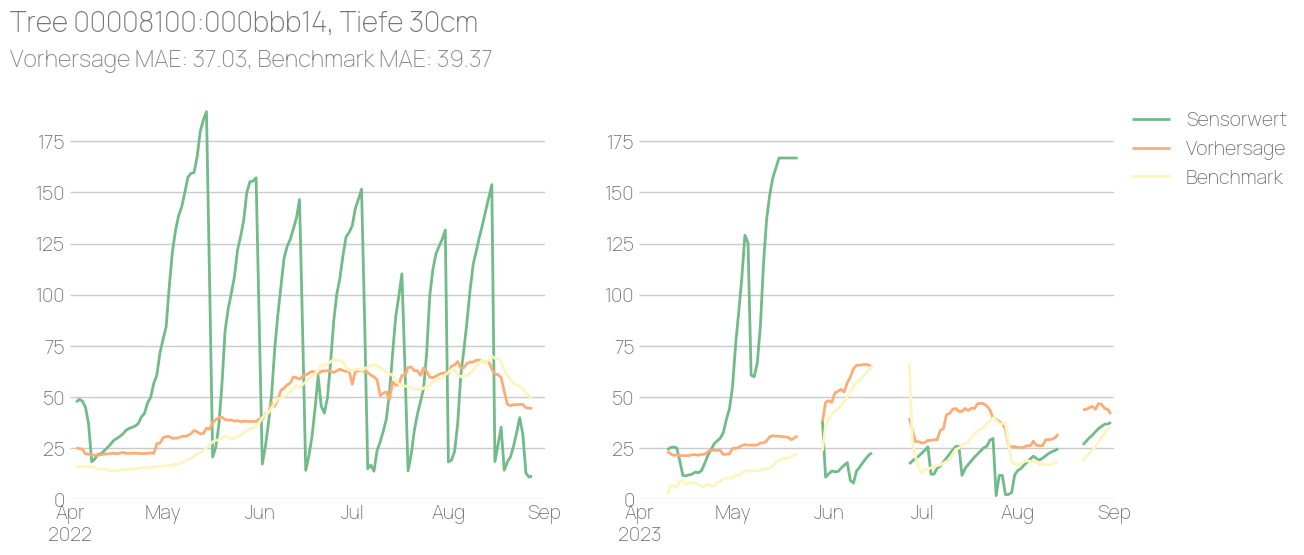

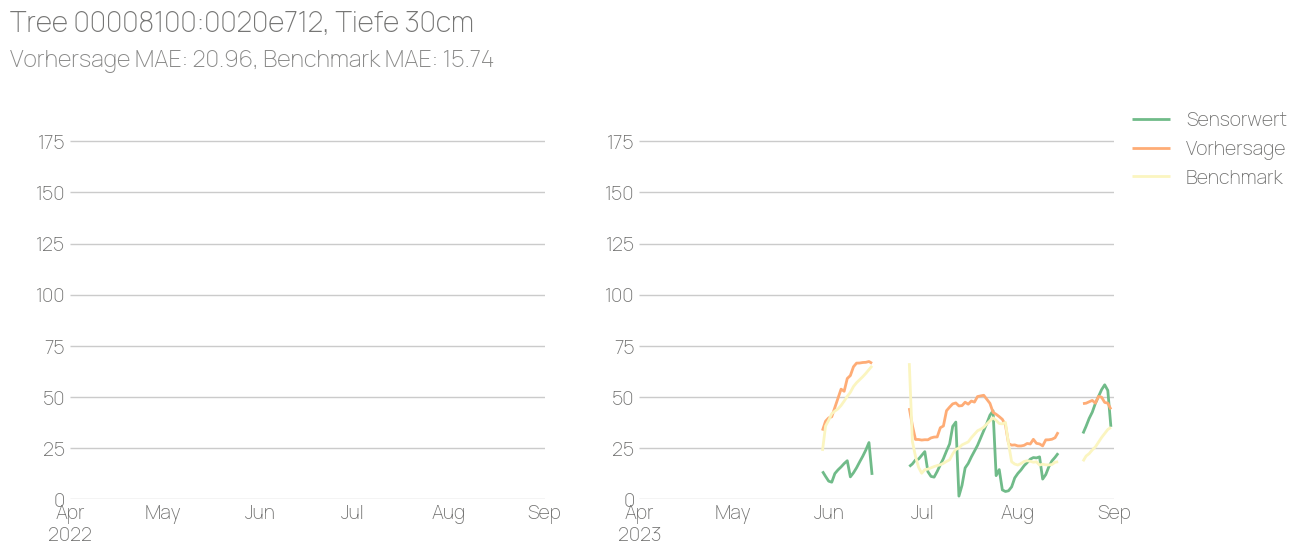

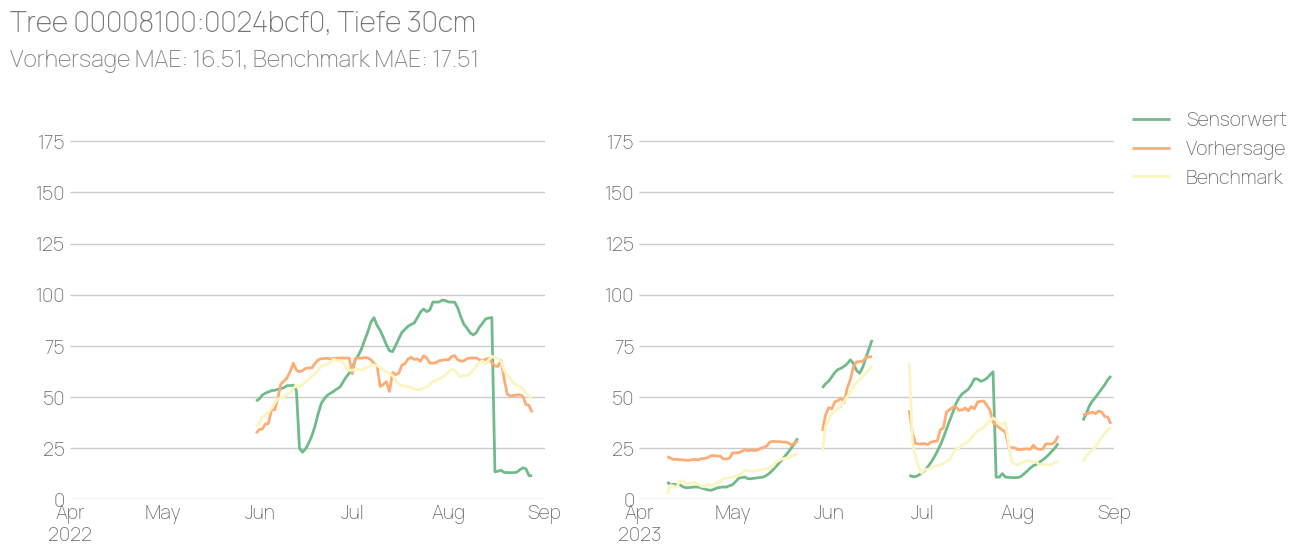

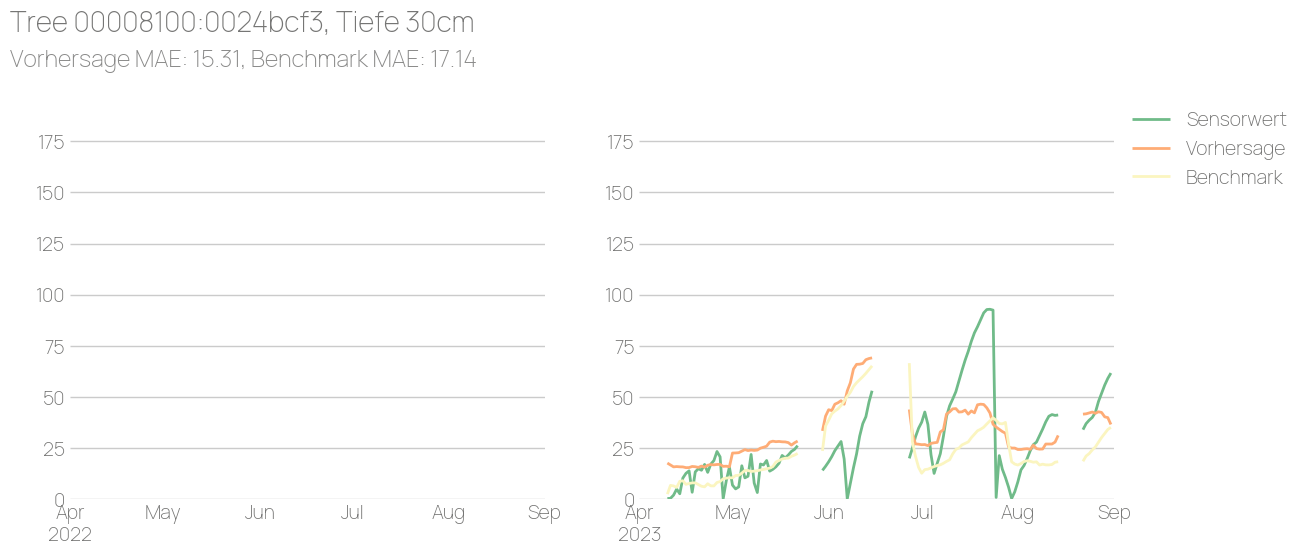

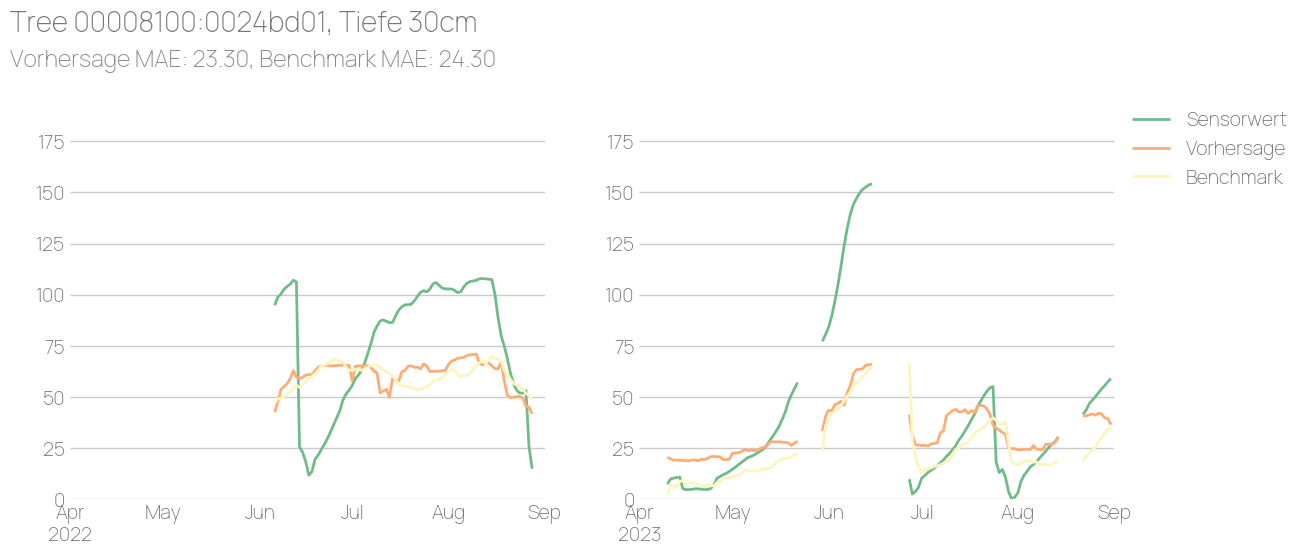

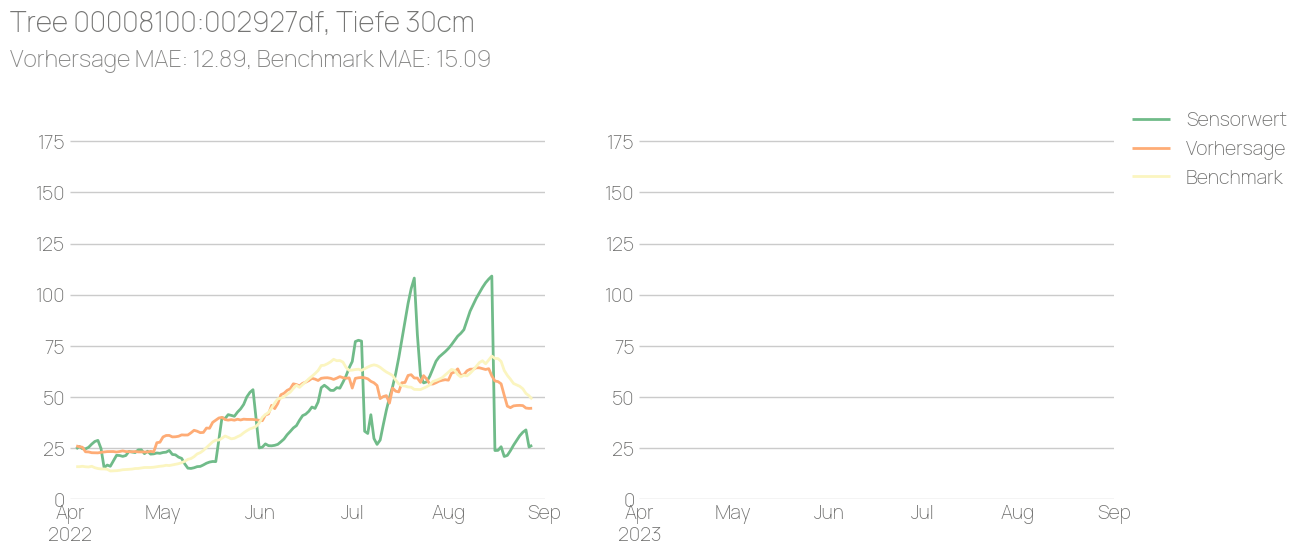

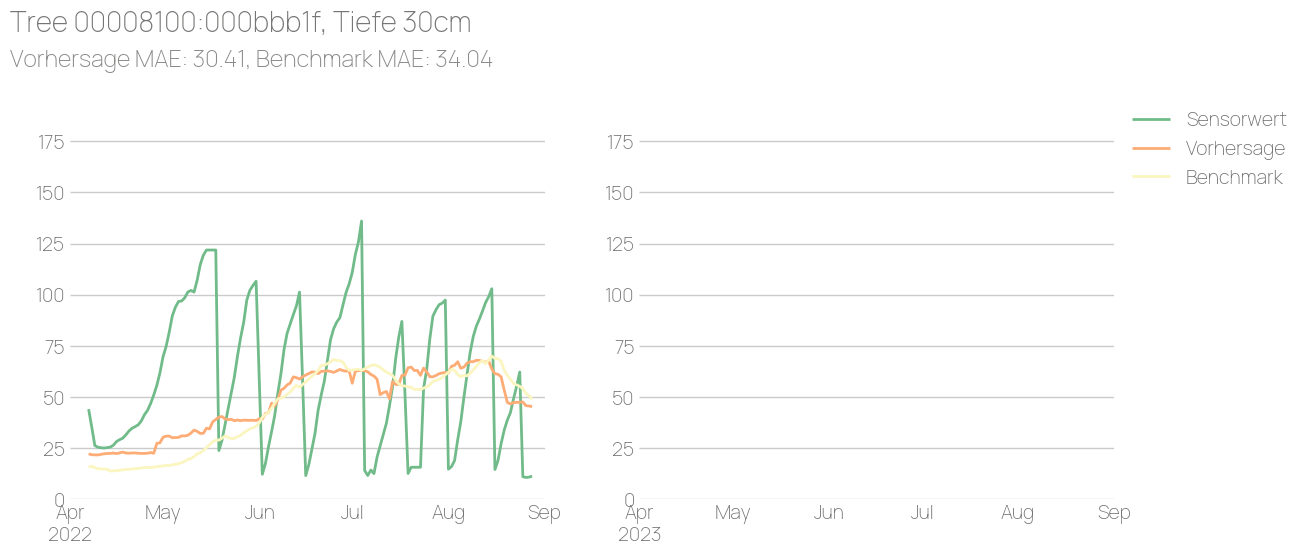

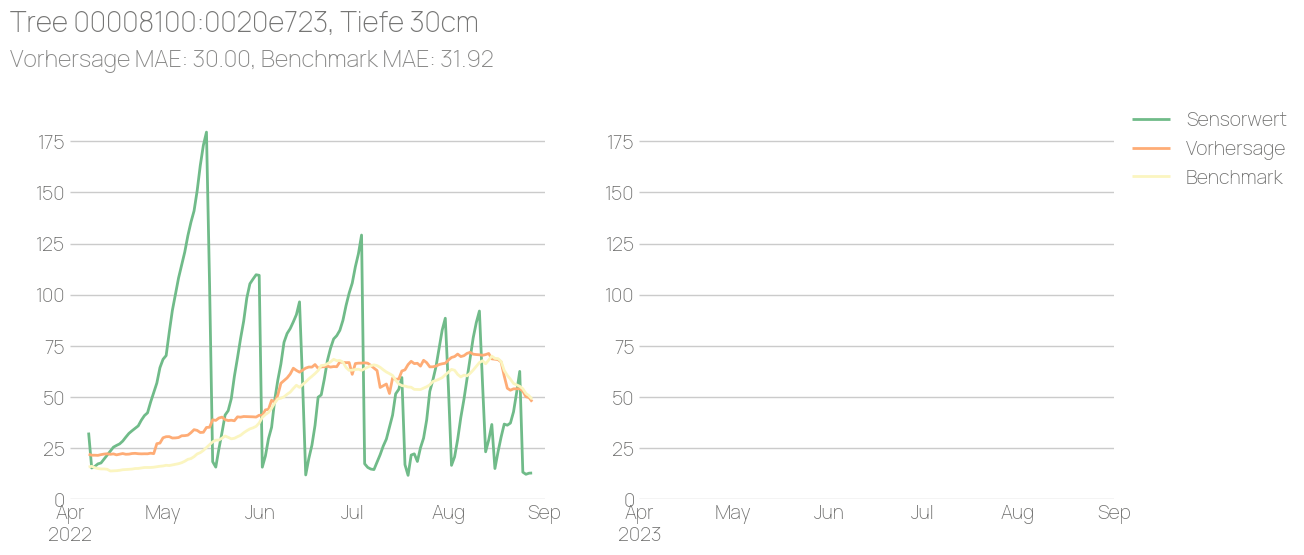

In [170]:
### Things to change
#for md in [2, 3, 4, 5, 8, 13]:
name = f"Slides MVP RF (no rain)" 
features=FEATURES_MVP # FEATURES_POC

hyper_parameters=dict(max_features="sqrt", n_estimators=1000, max_depth=5, bootstrap=True)
model = RandomForestRegressor(**hyper_parameters)

# hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42, loss="quantile", alpha=.5)
#hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
#model = GradientBoostingRegressor(**hyper_parameters)

#hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
#model = XGBRegressor(**hyper_parameters)

folds = create_train_test_split_across_sites(data, n_splits=4)
results, predictions = evaluate_folds(folds, name, model, hyper_parameters=hyper_parameters, features=features)

#results = evaluate_benchmark_on_folds(folds, log_experiment=True)

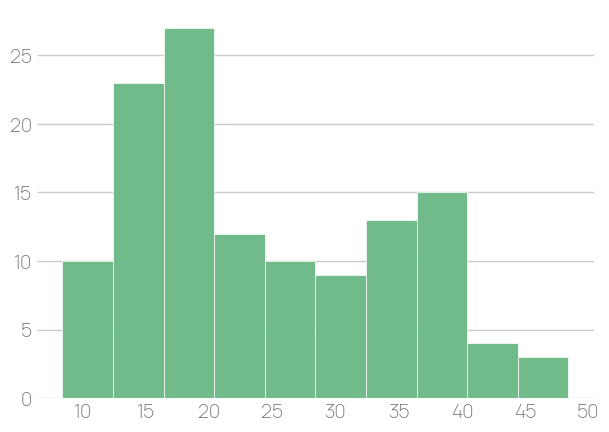

In [ ]:
predictions["errors"] = predictions["value"] - predictions["y_hat"] 
predictions["absolute_errors"] = abs(predictions["value"] - predictions["y_hat"])

aggregate_stats = predictions.groupby(["tree_id", "type_id"]).mean().reset_index().sort_values("absolute_errors")

aggregate_stats.absolute_errors.hist()
plt.gca().xaxis.grid(False)



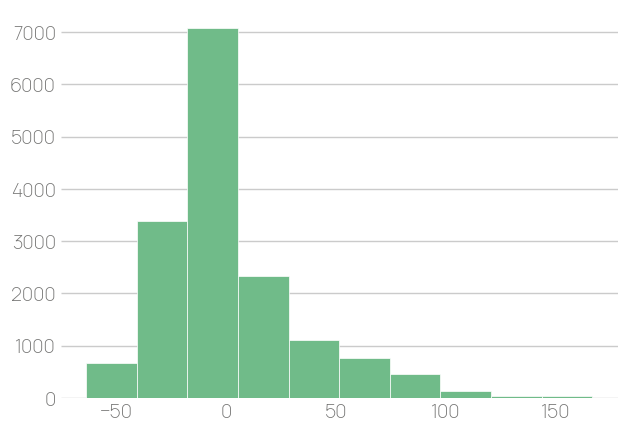

In [ ]:
predictions.errors.hist()
plt.gca().xaxis.grid(False)

In [ ]:
# find model that is less prone to jiggling
# consider AR featres